In [56]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
# Load the Excel file
df = pd.read_excel("tool_usage_data.xlsx")


In [5]:
df

,Input Time,Output Time,Location,Tool Type
0,2025-10-02 08:17:00,2025-10-02 08:36:00,Workshop 1,Drilling Bit
1,2025-10-02 08:21:00,2025-10-02 08:33:00,Workshop 1,Drilling Bit
2,2025-10-02 08:27:00,2025-10-02 08:53:00,Workshop 2,Milling Cutter
3,2025-10-02 08:30:00,2025-10-02 10:25:00,Workshop 1,Single Point Cutting Tool
4,2025-10-02 08:33:00,2025-10-02 09:47:00,Workshop 2,Single Point Cutting Tool
...,...,...,...,...
395,2025-10-09 15:59:00,2025-10-09 16:21:00,Workshop 1,Drilling Bit
396,2025-10-09 16:12:00,2025-10-09 18:03:00,Workshop 1,Single Point Cutting Tool
397,2025-10-09 16:24:00,2025-10-09 17:15:00,Workshop 1,Milling Cutter
398,2025-10-09 16:32:00,2025-10-09 18:28:00,Workshop 1,Single Point Cutting Tool


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Input Time   400 non-null    datetime64[ns]
 1   Output Time  400 non-null    datetime64[ns]
 2   Location     400 non-null    object        
 3   Tool Type    400 non-null    object        
dtypes: datetime64[ns](2), object(2)
memory usage: 12.6+ KB


In [8]:
# Ensure Input/Output times are datetime
df["Input Time"] = pd.to_datetime(df["Input Time"])
df["Output Time"] = pd.to_datetime(df["Output Time"])



In [ ]:
#  Usage Duration (minutes)
df["Usage Duration (min)"] = (df["Output Time"] - df["Input Time"]).dt.total_seconds() / 60


In [ ]:
#  Idle Time (minutes)
# Idle time = time gap between consecutive uses of the same tool in the same location
df = df.sort_values(by=["Tool Type", "Location", "Input Time"])
df["Prev Output Time"] = df.groupby(["Tool Type", "Location"])["Output Time"].shift(1)
df["Idle Time (min)"] = (df["Input Time"] - df["Prev Output Time"]).dt.total_seconds() / 60
df["Idle Time (min)"] = df["Idle Time (min)"].clip(lower=0)  # replace negatives with 0
df.drop(columns=["Prev Output Time"], inplace=True)


In [19]:
df.fillna( 0 , inplace = True)

In [ ]:
#  Daily Usage Frequency
df["Date"] = df["Input Time"].dt.date
daily_usage = (
    df.groupby(["Tool Type", "Location", "Date"])
    .size()
    .reset_index(name="Daily Usage Frequency")
)
df = df.merge(daily_usage, on=["Tool Type", "Location", "Date"], how="left")



In [ ]:
#  Cumulative Usage per Tool (minutes)
df["Cumulative Usage (min)"] = df.groupby(["Tool Type", "Location"])["Usage Duration (min)"].cumsum()


In [27]:
df

,Input Time,Output Time,Location,Tool Type,Usage Duration (min),Idle Time (min),Date,Daily Usage Frequency,Cumulative Usage (min)
0,2025-10-02 08:17:00,2025-10-02 08:36:00,Workshop 1,Drilling Bit,19.0,0.0,2025-10-02,10,19.0
1,2025-10-02 08:21:00,2025-10-02 08:33:00,Workshop 1,Drilling Bit,12.0,0.0,2025-10-02,10,31.0
2,2025-10-02 08:39:00,2025-10-02 09:07:00,Workshop 1,Drilling Bit,28.0,6.0,2025-10-02,10,59.0
3,2025-10-02 09:10:00,2025-10-02 09:24:00,Workshop 1,Drilling Bit,14.0,3.0,2025-10-02,10,73.0
4,2025-10-02 09:48:00,2025-10-02 10:08:00,Workshop 1,Drilling Bit,20.0,24.0,2025-10-02,10,93.0
...,...,...,...,...,...,...,...,...,...
395,2025-10-09 10:54:00,2025-10-09 12:10:00,Workshop 2,Single Point Cutting Tool,76.0,22.0,2025-10-09,9,4739.0
396,2025-10-09 13:13:00,2025-10-09 13:45:00,Workshop 2,Single Point Cutting Tool,32.0,63.0,2025-10-09,9,4771.0
397,2025-10-09 13:22:00,2025-10-09 15:06:00,Workshop 2,Single Point Cutting Tool,104.0,0.0,2025-10-09,9,4875.0
398,2025-10-09 15:06:00,2025-10-09 16:06:00,Workshop 2,Single Point Cutting Tool,60.0,0.0,2025-10-09,9,4935.0


In [ ]:
#  Rearrange columns for readability
cols = [
    "Input Time", "Output Time", "Date", "Location", "Tool Type",
    "Usage Duration (min)", "Idle Time (min)", "Daily Usage Frequency",
    "Cumulative Usage (min)"
]
df = df[cols]


In [29]:
df

,Input Time,Output Time,Date,Location,Tool Type,Usage Duration (min),Idle Time (min),Daily Usage Frequency,Cumulative Usage (min)
0,2025-10-02 08:17:00,2025-10-02 08:36:00,2025-10-02,Workshop 1,Drilling Bit,19.0,0.0,10,19.0
1,2025-10-02 08:21:00,2025-10-02 08:33:00,2025-10-02,Workshop 1,Drilling Bit,12.0,0.0,10,31.0
2,2025-10-02 08:39:00,2025-10-02 09:07:00,2025-10-02,Workshop 1,Drilling Bit,28.0,6.0,10,59.0
3,2025-10-02 09:10:00,2025-10-02 09:24:00,2025-10-02,Workshop 1,Drilling Bit,14.0,3.0,10,73.0
4,2025-10-02 09:48:00,2025-10-02 10:08:00,2025-10-02,Workshop 1,Drilling Bit,20.0,24.0,10,93.0
...,...,...,...,...,...,...,...,...,...
395,2025-10-09 10:54:00,2025-10-09 12:10:00,2025-10-09,Workshop 2,Single Point Cutting Tool,76.0,22.0,9,4739.0
396,2025-10-09 13:13:00,2025-10-09 13:45:00,2025-10-09,Workshop 2,Single Point Cutting Tool,32.0,63.0,9,4771.0
397,2025-10-09 13:22:00,2025-10-09 15:06:00,2025-10-09,Workshop 2,Single Point Cutting Tool,104.0,0.0,9,4875.0
398,2025-10-09 15:06:00,2025-10-09 16:06:00,2025-10-09,Workshop 2,Single Point Cutting Tool,60.0,0.0,9,4935.0


In [30]:
df.info( 
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Input Time              400 non-null    datetime64[ns]
 1   Output Time             400 non-null    datetime64[ns]
 2   Date                    400 non-null    object        
 3   Location                400 non-null    object        
 4   Tool Type               400 non-null    object        
 5   Usage Duration (min)    400 non-null    float64       
 6   Idle Time (min)         400 non-null    float64       
 7   Daily Usage Frequency   400 non-null    int64         
 8   Cumulative Usage (min)  400 non-null    float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(3)
memory usage: 28.3+ KB


In [ ]:
#  Daily total usage time (minutes) per tool per day (and per location)
daily_usage_time = (
    df.groupby(["Tool Type", "Location", "Date"])["Usage Duration (min)"]
    .sum()
    .reset_index(name="Daily Usage (min)")
)

# Merge back to main DataFrame
df = df.merge(daily_usage_time, on=["Tool Type", "Location", "Date"], how="left")


In [32]:
df

,Input Time,Output Time,Date,Location,Tool Type,Usage Duration (min),Idle Time (min),Daily Usage Frequency,Cumulative Usage (min),Daily Usage (min)
0,2025-10-02 08:17:00,2025-10-02 08:36:00,2025-10-02,Workshop 1,Drilling Bit,19.0,0.0,10,19.0,181.0
1,2025-10-02 08:21:00,2025-10-02 08:33:00,2025-10-02,Workshop 1,Drilling Bit,12.0,0.0,10,31.0,181.0
2,2025-10-02 08:39:00,2025-10-02 09:07:00,2025-10-02,Workshop 1,Drilling Bit,28.0,6.0,10,59.0,181.0
3,2025-10-02 09:10:00,2025-10-02 09:24:00,2025-10-02,Workshop 1,Drilling Bit,14.0,3.0,10,73.0,181.0
4,2025-10-02 09:48:00,2025-10-02 10:08:00,2025-10-02,Workshop 1,Drilling Bit,20.0,24.0,10,93.0,181.0
...,...,...,...,...,...,...,...,...,...,...
395,2025-10-09 10:54:00,2025-10-09 12:10:00,2025-10-09,Workshop 2,Single Point Cutting Tool,76.0,22.0,9,4739.0,660.0
396,2025-10-09 13:13:00,2025-10-09 13:45:00,2025-10-09,Workshop 2,Single Point Cutting Tool,32.0,63.0,9,4771.0,660.0
397,2025-10-09 13:22:00,2025-10-09 15:06:00,2025-10-09,Workshop 2,Single Point Cutting Tool,104.0,0.0,9,4875.0,660.0
398,2025-10-09 15:06:00,2025-10-09 16:06:00,2025-10-09,Workshop 2,Single Point Cutting Tool,60.0,0.0,9,4935.0,660.0


In [43]:
import numpy as np
import math
df["Tool Type"] = df["Tool Type"].str.strip().str.lower()

# Now define tool life dictionary in lowercase and matching format
tool_life = {
    "single point cutting tool": 120,
    "drilling bit": 60,
    "milling cutter": 180
}

# Map tool life again
df["Tool Life (min)"] = df["Tool Type"].map(tool_life)


In [72]:
df_final = df 
df_final.to_csv('final_tool_features.csv', index=False)


In [71]:
df_final

,Input Time,Output Time,Date,Location,Tool Type,Usage Duration (min),Idle Time (min),Daily Usage Frequency,Cumulative Usage (min),Daily Usage (min),Tool Life (min)
0,2025-10-02 08:17:00,2025-10-02 08:36:00,2025-10-02,Workshop 1,drilling bit,19.0,0.0,10,19.0,181.0,60
1,2025-10-02 08:21:00,2025-10-02 08:33:00,2025-10-02,Workshop 1,drilling bit,12.0,0.0,10,31.0,181.0,60
2,2025-10-02 08:39:00,2025-10-02 09:07:00,2025-10-02,Workshop 1,drilling bit,28.0,6.0,10,59.0,181.0,60
3,2025-10-02 09:10:00,2025-10-02 09:24:00,2025-10-02,Workshop 1,drilling bit,14.0,3.0,10,73.0,181.0,60
4,2025-10-02 09:48:00,2025-10-02 10:08:00,2025-10-02,Workshop 1,drilling bit,20.0,24.0,10,93.0,181.0,60
...,...,...,...,...,...,...,...,...,...,...,...
395,2025-10-09 10:54:00,2025-10-09 12:10:00,2025-10-09,Workshop 2,single point cutting tool,76.0,22.0,9,4739.0,660.0,120
396,2025-10-09 13:13:00,2025-10-09 13:45:00,2025-10-09,Workshop 2,single point cutting tool,32.0,63.0,9,4771.0,660.0,120
397,2025-10-09 13:22:00,2025-10-09 15:06:00,2025-10-09,Workshop 2,single point cutting tool,104.0,0.0,9,4875.0,660.0,120
398,2025-10-09 15:06:00,2025-10-09 16:06:00,2025-10-09,Workshop 2,single point cutting tool,60.0,0.0,9,4935.0,660.0,120


In [45]:
df.info(
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Input Time              400 non-null    datetime64[ns]
 1   Output Time             400 non-null    datetime64[ns]
 2   Date                    400 non-null    object        
 3   Location                400 non-null    object        
 4   Tool Type               400 non-null    object        
 5   Usage Duration (min)    400 non-null    float64       
 6   Idle Time (min)         400 non-null    float64       
 7   Daily Usage Frequency   400 non-null    int64         
 8   Cumulative Usage (min)  400 non-null    float64       
 9   Daily Usage (min)       400 non-null    float64       
 10  Tool Life (min)         400 non-null    int64         
dtypes: datetime64[ns](2), float64(4), int64(2), object(3)
memory usage: 34.5+ KB


<Axes: xlabel='Date', ylabel='Daily Usage (min)'>

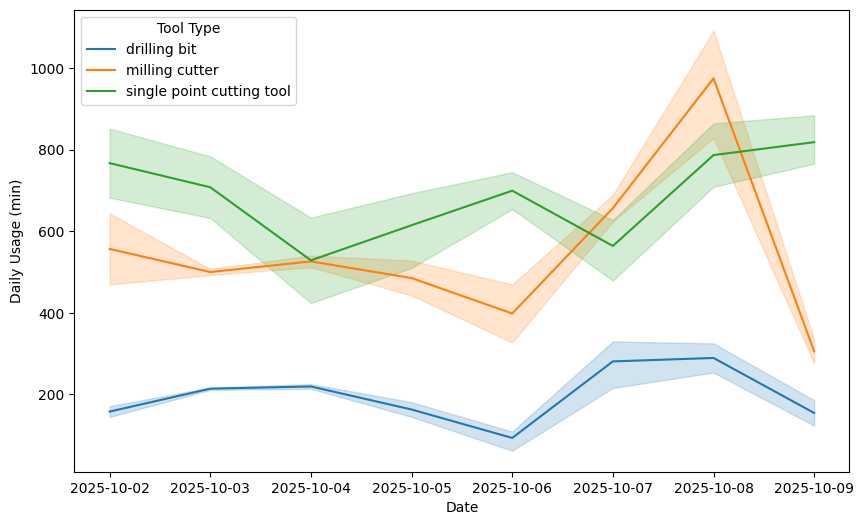

In [ ]:
''' Daily Usage Trends

Goal: See how tool usage changes over time.

'''

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Date', y='Daily Usage (min)', hue='Tool Type')


<Axes: xlabel='Tool Type', ylabel='Time (min)'>

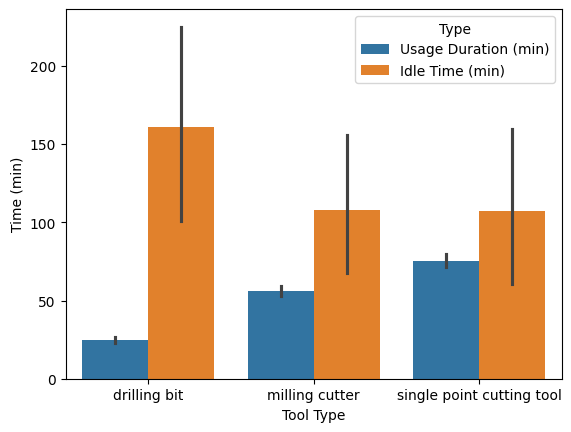

In [ ]:
'''  Tool Efficiency

Goal: Compare how much of the total tool time is idle vs active.
'''

df_melt = df.melt(id_vars=['Tool Type', 'Location', 'Date'], 
                  value_vars=['Usage Duration (min)', 'Idle Time (min)'],
                  var_name='Type', value_name='Time (min)')
sns.barplot(data=df_melt, x='Tool Type', y='Time (min)', hue='Type')


<Axes: xlabel='Tool Type', ylabel='Daily Usage (min)'>

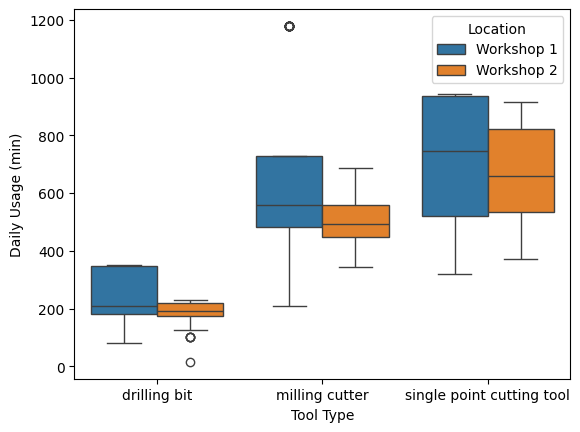

In [ ]:
''' Usage Distribution per Tool and Workshop

Goal: Compare distribution of daily usage or idle times.
'''

sns.boxplot(data=df, x='Tool Type', y='Daily Usage (min)', hue='Location')


<Axes: xlabel='Tool Type', ylabel='Daily Usage Frequency'>

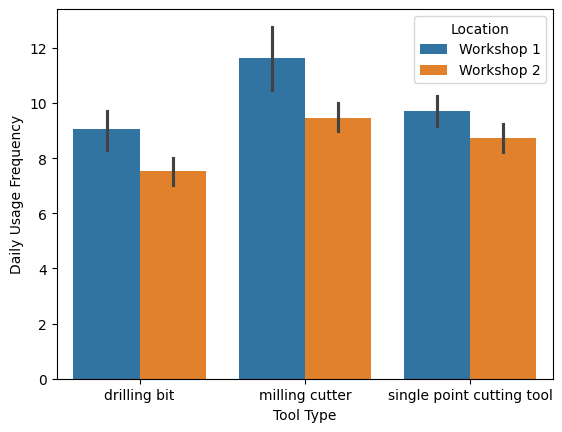

In [ ]:
'''  
Daily Usage Frequency Pattern

Goal: Understand how often tools are used per day.
'''

sns.barplot(data=df, x='Tool Type', y='Daily Usage Frequency', hue='Location')


<Axes: xlabel='Date', ylabel='Tool Type'>

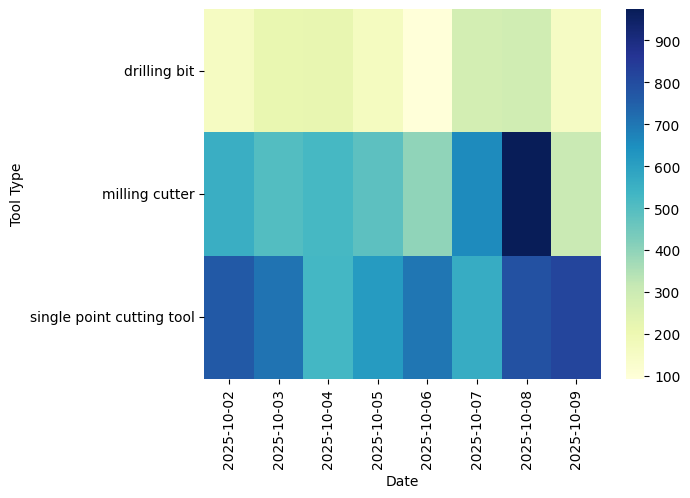

In [ ]:
''' 
Heatmap: Tool Usage Over Time

Goal: Identify days of high vs low usage for each tool.
'''

usage_pivot = df.pivot_table(values='Daily Usage (min)', index='Tool Type', columns='Date')
sns.heatmap(usage_pivot, cmap='YlGnBu')


<Axes: xlabel='Location', ylabel='Daily Usage (min)'>

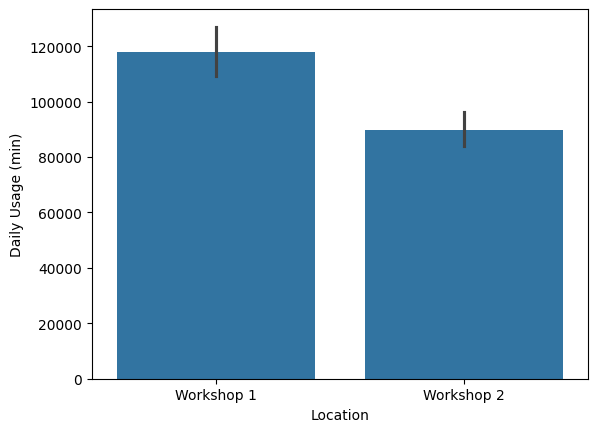

In [ ]:
''' 
Total Usage by Workshop

Goal: Compare overall productivity between the two workshops.'''

sns.barplot(data=df, x='Location', y='Daily Usage (min)', estimator='sum')


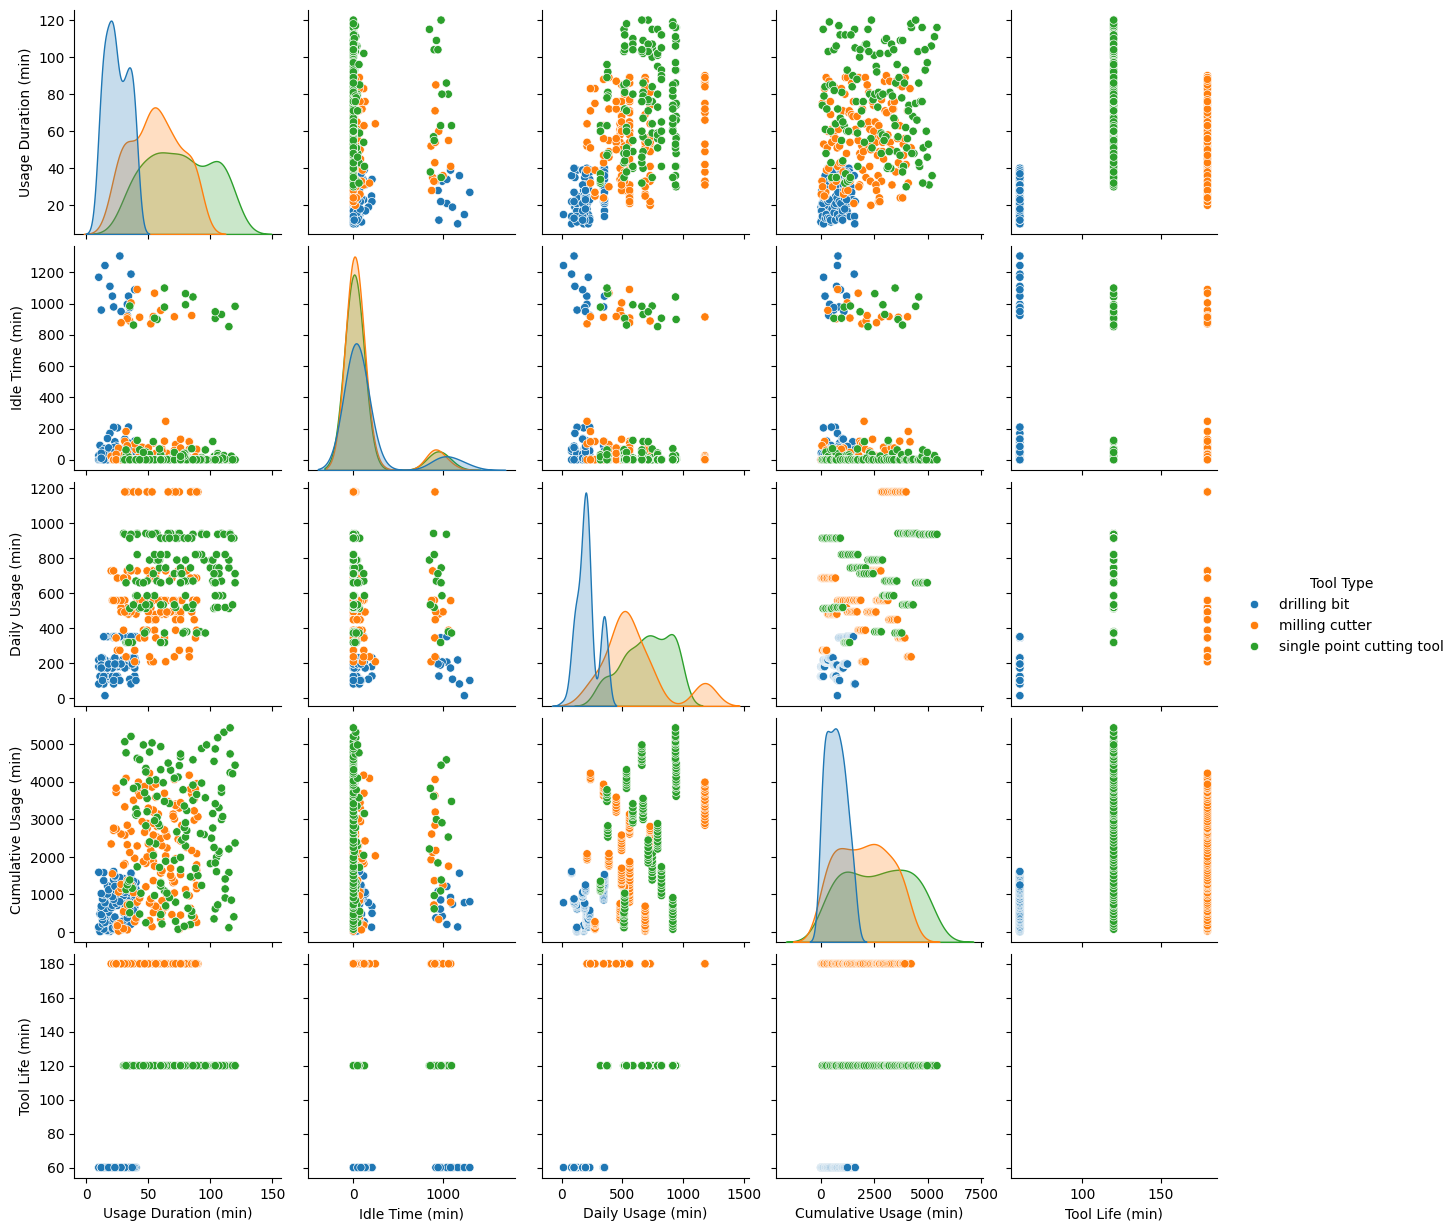

In [ ]:
''' 
Pairplot for Quick Relationship Overview

Goal: Explore all numeric relationships in one go.
'''


sns.pairplot(df, hue='Tool Type', vars=[
    'Usage Duration (min)', 'Idle Time (min)', 
    'Daily Usage (min)', 'Cumulative Usage (min)', 'Tool Life (min)'
])
